<a href="https://colab.research.google.com/github/TheBlock98/Thesis/blob/main/CNNLSTMNeuroProbModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Modello neuro probabilistico configurazione Youthful4Model CNNLSTM24h OC2


questa è la versione base bisogna fare delle verifiche su come vengono inizializzati i pesi confrontandosi con gli articoli

In [1]:
config = {
    "alphaRMS": 0.8878535830123158,
    "batch_size": 128,
    "window_size": 176,
    "device": "cuda",
    "dimTrValDataSet": 0.8135103108199945,
    "dropout": 0.5255918882358939,
    "eps": 0.00000001809781643808,
    "input_size": 61,
    "l1_factor": 0.00001788764196672363,
    "l1_lambda": 0.00985428675707348,
    "learning_rateAdam": 0.000654610999498754,
    "learning_rateRMS": 0.04441832592851753,
    "momentumRMS": 0.726408866481537,
    "nStepsAhead": 24,
    "min_delta": 0.007955514357042039,
    "num_epochs": 850,
    "num_lstm_layers": 3,
    "optimizer": "Adam",
    "patience": 150,
    "scheduler": "ReduceLROnPlateau",
    "scheduler_factorCosineAnnealingWarmRestarts": 1.1189226291910723,
    "scheduler_ReduceLROnPlateau": 0.7502387107470798,
    "scheduler_min_lrCosineAnnealingWarmRestarts": 0.0000986804709547241,
    "scheduler_min_lrReduceLROnPlateau": 0.00025800234809786196,
    "scheduler_patienceCosineAnnealingWarmRestarts": 5.485778505433907,
    "scheduler_patienceReduceLROnPlateau": 8.645318720669717,
    "test_split_size": 0.14632058556123811,
    "trW": 20,
    "vlWl": 17,
    "weight_decayAdam": 0.0008131241983869834,
    "weight_decayRMS": 0.004928825586952906,

}



In [2]:
pip install wandb

In [3]:
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import wandb
from sklearn.preprocessing import MinMaxScaler
import statistics as stat

wandb.login()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

seed = 456
np.random.seed(seed);
torch.manual_seed(seed);
torch.set_default_dtype(torch.float64)


wandb: Currently logged in as: stefanobutera98. Use `wandb login --relogin` to force relogin


# DataSet

In [4]:
# Dataset download
dataSetClean = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FeatureEngineering&DATA/dataSetIMRCleanedLC2.csv")
lc2 = dataSetClean['lc2']
dataSetClean.drop(labels=['lc2'], axis=1, inplace=True)
oc2 = (dataSetClean['open']+ dataSetClean['close'])/2
dataSetClean.insert(0, 'oc2', oc2)
dataSetClean.replace([np.inf, -np.inf], np.nan, inplace=True)
dataSetClean.fillna(method='ffill', inplace=True)
dataSetClean.fillna(method='bfill', inplace=True)
dataSetClean.info()


# Dataloading (sliding windows)
config["input_size"] = 61  # with 1 have number of features

# Normalize
scaler = MinMaxScaler()
scaler.fit(dataSetClean)
dataSet = scaler.transform(dataSetClean)
dataSet = pd.DataFrame(dataSet)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52433 entries, 0 to 52432
Data columns (total 61 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oc2                  52433 non-null  float64
 1   open                 52433 non-null  float64
 2   high                 52433 non-null  float64
 3   low                  52433 non-null  float64
 4   close                52433 non-null  float64
 5   volume               52433 non-null  float64
 6   volume_quote         52433 non-null  float64
 7   trades               52433 non-null  int64  
 8   taker_buy            52433 non-null  float64
 9   taker_buy_quote      52433 non-null  float64
 10  EMA_21               52433 non-null  float64
 11  EMA_50               52433 non-null  float64
 12  EMA_200              52433 non-null  float64
 13  ATR                  52433 non-null  float64
 14  ATR_168              52433 non-null  float64
 15  RSI                  52433 non-null 

## Plot distribution of target variable (OC2)

In [5]:
"""
_, ax = plt.subplots(1, 1, figsize=(10, 5))
dataSet.loc[].hist(bins=50, ax=ax);
ax.set_title('Plot distribution of target variable (OC2)');
ax.set_xlabel('Value');
ax.set_ylabel('Count');
"""

"\n_, ax = plt.subplots(1, 1, figsize=(10, 5))\ndataSet.loc[].hist(bins=50, ax=ax);\nax.set_title('Plot distribution of target variable (OC2)');\nax.set_xlabel('Value');\nax.set_ylabel('Count');\n"

In [6]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        super(). __init__()
        self.X_data = X_data
        self.y_data = y_data


    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]


def getDataSet(x,y):
    dataSet = TimeSeriesDataset(x, y)
    return dataSet


def getDataLoader(dataSet,config):
  loader = DataLoader(dataset=dataSet,
                          batch_size=config.batch_size,
                          shuffle=False)
  return loader



In [7]:
# function to divide the dataSet into windows (X lenght = window_size; Y lenght = nStepsAhead)

def slidingWindowsAhead(df, windowSize, nStepsAhead,dimTrValDataSet):
  x = []
  y = []
  dataLen = df.shape[0] # n rows
  for i in range(windowSize, dataLen, nStepsAhead):
      if i + nStepsAhead > dataLen:
          break  # If we do not have enough data to predict further, we break the loop.
    # '_x' will contain 'windowSize' values as input data
      _x = df.iloc[i-windowSize:i].values
    # '_y' will contain 'nStepsAhead' values as labels
      _y = df.iloc[i:i+nStepsAhead, 0].values
      x.append(_x)
      y.append(_y)

  # convert windows in tensor
  np.array(x)
  np.array(y)
  trVlWnum = int(len(x) * dimTrValDataSet)
  testWnum = len(x) - trVlWnum  # Remaining data for testing

  trVlX = x[:trVlWnum]
  testX = x[trVlWnum:]
  trVlY = y[:trVlWnum]
  testY = y[trVlWnum:]

  print("_______ Dim mX & mY ______")
  print(f"dim mX:{len(x)} dim mY:{len(y)}")
  print("_____Dimension X & Y _____")
  print(f"dim trValX:{len(trVlX)} --- dim trValY:{len(trVlY)} ")

  print(f"dim testX:{len(testX)} --- dim testY:{len(testY)} ")

  # Convert from numpy arrays to torch tensors
  trVlX_tensor = torch.tensor(trVlX, dtype=torch.float32)
  trVlY_tensor = torch.tensor(trVlY, dtype=torch.float32).unsqueeze(1)
  testX_tensor = torch.tensor(testX, dtype=torch.float32)
  testY_tensor = torch.tensor(testY, dtype=torch.float32).unsqueeze(1)

  print("_____Dimension X & Y tensor _____")
  print(f"dim TR&VAL X:{trVlX_tensor.shape} --- dim TR&VAL Y:{trVlY_tensor.shape} ")
  print(f"dim TEST X:{testX_tensor.shape} --- dim TEST Y:{testY_tensor.shape} ")

  print(f"trVlX_tensor{trVlX_tensor[:10]}")
  print(f"trVlX_tensor{trVlY_tensor[:10]}")


  return trVlX_tensor,trVlY_tensor,testX_tensor,testY_tensor

# Model design

In [8]:
class CNNLSTMModel(nn.Module):

  def __init__(self, input_size, num_lstm_layers, dropout,
               sequence_length,nStepsAhead):
    super().__init__()
    self.jitter = 1e-6

    # model definition
    self.hybridNetwork = nn.Sequential(
        nn.Conv1d(in_channels=input_size,
                  out_channels=sequence_length,
                  kernel_size=1),
        nn.ReLU(),
        nn.LSTM(input_size=sequence_length,
                hidden_size=sequence_length,
                num_layers=num_lstm_layers,
                dropout=dropout,
                batch_first=False),
    )
    self.endLinearLayer = nn.Linear(sequence_length,2 * nStepsAhead)

  def forward(self, x):
    # Apply CNN layers
    x = x.permute(0, 2, 1)
    x = self.hybridNetwork[0](x)  # Conv1d
    x = self.hybridNetwork[1](x)  # ELU activation

    # Permute the dimensions for LSTM
    x = x.permute(2, 0, 1)

    # Apply LSTM layers
    x, (hidden, cell) = self.hybridNetwork[2](x)

    # Only take the output from the last time-step
    x = x[-1, :, :]

    # Apply final linear layer
    x = self.endLinearLayer(x)
    means ,variances = x.chunk(2, dim = -1)
    variances = self.jitter + variances
    variances = torch.clamp(variances, min=1e-3)  # Enforce a minimum positive variance
    distributions = torch.distributions.Normal(means, variances)


    return distributions


# Service objects

In [9]:
def compute_loss(model, x, y, kl_reg=0.1):
    y_hat = model(x)
    neg_log_likelihood = -y_hat.log_prob(y)
    return torch.mean(neg_log_likelihood),y_hat

In [10]:
def getOptimizer(model,config):
  if config.optimizer == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rateAdam, betas=(0.9, 0.999), eps=config.eps, weight_decay=config.weight_decayAdam, amsgrad=False, foreach=None, maximize=False, capturable=False, differentiable=False, fused=None)
  elif config.optimizer == "RMSprop":
    optimizer = torch.optim.RMSprop(model.parameters(), lr=config.learning_rateRMS, alpha=config.alphaRMS, eps=config.eps, weight_decay=config.weight_decayRMS, momentum=config.momentumRMS, centered=True, foreach=None, maximize=False, differentiable=False)
  else:
    optimizer = None
  return optimizer


In [11]:
def getScheduler(optimizer,config):
  if config.scheduler == "ReduceLROnPlateau":
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=config["scheduler_ReduceLROnPlateau"], patience=config["scheduler_patienceReduceLROnPlateau"], min_lr=config["scheduler_min_lrReduceLROnPlateau"])
  elif config.scheduler == "CosineAnnealingWarmRestarts":
        T_0 = round(config.scheduler_patienceCosineAnnealingWarmRestarts)
        T_mult = int(config.scheduler_factorCosineAnnealingWarmRestarts)  # Force integer conversion
        eta_min = config.scheduler_min_lrCosineAnnealingWarmRestarts  # Assuming this is OK.
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=T_mult, eta_min=eta_min)
  else:
    scheduler = None
  return scheduler



In [12]:
def getNweights(model):
  nweights = 0
  for name,weights in model.named_parameters():
    if 'bias' not in name:
      nweights = nweights + weights.numel()

  return nweights

In [13]:
def compute_rmse(model, y_hat, y_test, num_samples=1000):
    y_hat_samples = y_hat.sample((num_samples,))  # Draw multiple samples

    errors = y_hat_samples - y_test  # Calculate errors for each sample
    squared_errors = errors ** 2
    mean_squared_error = torch.mean(squared_errors, dim=0)  # Average across samples
    rmse = torch.sqrt(mean_squared_error)

    return rmse


In [14]:
def flatten_if_nested(lst):

    # Initialize an empty list to store the flattened elements
    flat_list = []

    # Iterate through each element in the input list
    for item in lst:
        # If the element is a list, extend the flat list with the flattened version of this element
        if isinstance(item, list):
            flat_list.extend(flatten_if_nested(item))
        # If the element is not a list, simply append it to the flat list
        else:
            flat_list.append(item)

    return flat_list
# Example usage:
nested_list = [1, [2, 3], [4, [5, 6, [7]]], 8]
flat_list = flatten_if_nested(nested_list)
print(flat_list)


[1, 2, 3, 4, 5, 6, 7, 8]


In [15]:
class ValidationLossEarlyStopping:
    def __init__(self, patience=1, min_delta=0.0):
        self.patience = patience  # number of times to allow for no improvement before stopping the execution
        self.min_delta = min_delta  # the minimum change to be counted as improvement
        self.counter = 0  # count the number of times the validation accuracy not improving
        self.min_validation_loss = float('inf')

    # return True when validation loss is not decreased by the `min_delta` for `patience` times
    def early_stop_check(self, validation_loss,epoch):
      if epoch > 300:
        if ((validation_loss+self.min_delta) < self.min_validation_loss):
            self.min_validation_loss = validation_loss
            self.counter = 0  # reset the counter if validation loss decreased at least by min_delta
        elif ((validation_loss+self.min_delta) > self.min_validation_loss):
            self.counter += 1 # increase the counter if validation loss is not decreased by the min_delta
            if self.counter >= self.patience:
                return True
        return False
      return False

# Loop services


In [16]:
def trainLoop(model,config,loader,optimizer,all_predictionsTR,all_targetsTR,nweights):
  model.train()
  train_loss = 0
  losses_t, rmse_v = [], []
  for _, (data,target) in enumerate(loader):

    optimizer.zero_grad()
    data, target = data.to(config.device), target.to(config.device)
    target = target.squeeze(1)
    # Forward pass ➡
    loss,y_hat = compute_loss(model, data, target)
      # reg L1
    L1_term = torch.tensor(0., requires_grad=True).to(config.device)

    for name, weights in model.named_parameters():
        if 'bias' not in name:
          L1_term += torch.sum(torch.abs(weights))
    L1_term /= nweights
    loss += L1_term * config.l1_lambda
    loss.backward()
    optimizer.step()
    b_val_rmse = compute_rmse(model, y_hat, target)
    losses_t.append(loss.detach().cpu().numpy())
    rmse_v.append(b_val_rmse.detach().cpu().numpy())
    #means = y_hat.loc.tolist()
    #std_devs = y_hat.scale.tolist()

    all_predictionsTR.append(y_hat)
    all_targetsTR.extend(
            target.squeeze().tolist())

  losses_t = np.array(losses_t)
  avg_loss = np.mean(losses_t)
  avg_rmse_v = np.mean(np.array(rmse_v))
  return avg_loss,avg_rmse_v


""" serve aggiungere una regolarizzazione e valutare l'inizzializzazione dei pesi come da paper ma questa è una versione di base per capire eventuali problemi """




" serve aggiungere una regolarizzazione e valutare l'inizzializzazione dei pesi come da paper ma questa è una versione di base per capire eventuali problemi "

In [17]:
def validationLoop(model,config,loader,optimizer,all_predictionsVL,all_targetsVL):
  model.eval()
  losses_v, rmse_v = [], []
  with torch.no_grad():
    for _, (data,target) in enumerate(loader):
      data, target = data.to(config.device), target.to(config.device)
      target = target.squeeze(1)
      # Forward pass ➡
      loss,y_hat = compute_loss(model, data, target)
      b_val_rmse = compute_rmse(model, y_hat, target)
      losses_v.append(loss.detach().cpu().numpy())
      rmse_v.append(b_val_rmse.detach().cpu().numpy())
      #means = y_hat.loc.tolist()
      #std_devs = y_hat.scale.tolist()

      all_predictionsVL.append(y_hat)
      all_targetsVL.extend(
            target.squeeze().tolist())
  losses_v = np.array(losses_v)
  avg_loss = np.mean(losses_v)
  avg_rmse_v = np.mean(np.array(rmse_v))
  return avg_loss,avg_rmse_v

In [18]:
def testLoop(model, testX_tensor,testY_tensor,config):
  all_predictionsVL = []
  all_targetsVL = []
  model.eval()
  losses_v, rmse_v = [], []
  dataSetTS = getDataSet(testX_tensor,testY_tensor)
  test_loader =getDataLoader(dataSetTS,config)
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
      data, target = data.to(config.device), target.to(
        config.device)
      target = target.squeeze(1)
      # Forward pass ➡
      loss,y_hat = compute_loss(model, data, target)
      #b_val_rmse = compute_rmse(model, y_hat, target)
      losses_v.append(loss.detach().cpu().numpy())
      #rmse_v.append(b_val_rmse.detach().cpu().numpy())
      #means = y_hat.loc.tolist()
      #std_devs = y_hat.scale.tolist()

      all_predictionsVL.append(y_hat)
      all_targetsVL.extend(
            target.squeeze().tolist())
  losses_v = np.array(losses_v)
  avg_loss = np.mean(losses_v)

  return avg_loss,all_predictionsVL,all_targetsVL

# Traning and Validation in rolling windows

In [19]:
TRLossHist = [] # per ogni epoca ho la loss di tutte le finestre training
TRRmseHist = []

VLLossHist = []
VLRmseHist = []

class ResultManager():
  def __init__(self,predTR,predVL,targetTR,targetVL,targetTS = 0,predTS = 0):
    self.predTR = predTR
    self.predVL = predVL
    self.predTS = predTS
    self.targetTR = targetTR
    self.targetVL = targetVL
    self.targetTS = targetTS

  def setPredTS(self,predTS):
    self.predTS = predTS

  def setTargetTS(self,targetTS):
    self.targetTS = targetTS

  def getPredTR(self):
    return self.predTR

  def getPredVL(self):
    return self.predVL

  def getPredTS(self):
    return self.predTS

  def getTargetTR(self):
    return self.targetTR

  def getTargetVL(self):
    return self.targetVL

  def getTargetTS(self):
    return self.targetTS

  def getResultDef(pred):
    means_data = []
    devs_data = []

    for y_hat in pred:
        means_data.extend(y_hat.loc.tolist())
        devs_data.extend(y_hat.scale.tolist())

    df = pd.DataFrame({ 'means': means_data, 'devs': devs_data })
    return df




In [20]:
import math
def trWvalWalg(model, trVlX_tensor,trVlY_tensor, optimizer,scheduler, config,earlyStopper,nWeights):
  """ algoritmo per il training e la validazione su rolling windows in continuo """
# aggiungere i run per hyperparameters sweep
  nweights = getNweights(model)
  wandb.watch(model, log="all")


  for epoch in range(config.num_epochs):
    train_loss = 0
    val_loss = 0

    all_avgLossTR = []
    all_avgLossVL = []

    all_avgRmseTR = []
    all_avgRmseVL = []

    all_predictionsTR = []
    all_targetsTR = []

    all_predictionsVL = []
    all_targetsVL = []

    print(f"_______Epoch {epoch}/{config.num_epochs}:_______ \n")

    for i in range(0, len(trVlX_tensor), config["trW"] + config["vlWl"]):
      train_indices = slice(i, i + config["trW"])
      val_indices = slice(i + config["trW"], i + config["trW"] + config["vlWl"])

      if len(trVlX_tensor[train_indices]) > 0:
        model.train()
        train_dataset = getDataSet(trVlX_tensor[train_indices], trVlY_tensor[train_indices])
        train_loader  = getDataLoader(train_dataset,config)

        # training
        avg_lossTR,avg_rmseTR = trainLoop(model,config,train_loader,optimizer,all_predictionsTR,all_targetsTR,nWeights)

        typeW = "training"
        all_avgLossTR.append(avg_lossTR)
        all_avgRmseTR.append(avg_rmseTR)
        wandb.log({"trainLossWindows":avg_lossTR, "trainRmseWindows": avg_rmseTR, "nWindows":i, "Windows type":typeW, "Epoch":epoch })

      if len(trVlX_tensor[val_indices]) > 0:
        model.eval()
        val_dataset = getDataSet(trVlX_tensor[train_indices], trVlY_tensor[train_indices])
        val_loader  = getDataLoader(val_dataset,config)

        #validation
        avg_lossVL,avg_rmseVL = validationLoop(model,config,val_loader,optimizer,all_predictionsVL,all_targetsVL)

        typeW = "validation"
        all_avgLossVL.append(avg_lossVL)
        all_avgRmseVL.append(avg_rmseVL)
        wandb.log({"validationLossWindows":avg_lossVL,"ValRmseWindows": avg_rmseVL, "nWindows":i, "Windows type":typeW, "Epoch":epoch })
    if not math.isnan(avg_lossVL):
          scheduler.step(avg_lossVL)

    if earlyStopper.early_stop_check(avg_lossVL,epoch):
      print(f"arlyStopper was triggered at epoch:{epoch}")
      avgLossTr = stat.mean(all_avgLossTR)
      avgRmseTr = stat.mean(all_avgRmseTR)

      avgLossVl = stat.mean(all_avgLossVL)
      avgRmseVl = stat.mean(all_avgRmseVL)

      TRLossHist.append(avgLossTr) # per ogni epoca ho la loss di tutte le finestre training
      TRRmseHist.append(avgRmseTr)

      VLLossHist.append(avgLossVl) # per ogni epoca ho la loss di tutte le finestre di validazione
      VLRmseHist.append(avgRmseVl)

      wandb.log({"trainLossEpoch":avgLossTr,"trainRmseEpoch":avgRmseTr,   "Epoch":epoch })
      wandb.log({"valLossEpoch":avgLossVl,"validationRmseEpoch":avgRmseVl,  "Epoch":epoch })
      print(f"MeanTrain Loss: {avgLossTr} \n MeanTrain RMSE: {avgRmseTr} \n   MeanVal Loss : {avgLossVl} \n  MeanVal RMSE: {avgRmseVl} \n")



      resultManager = ResultManager(all_predictionsTR,all_targetsTR,all_predictionsVL,all_targetsVL)
      return resultManager

    # scheduler
    avgLossTr = stat.mean(all_avgLossTR)
    avgRmseTr = stat.mean(all_avgRmseTR)

    avgLossVl = stat.mean(all_avgLossVL)
    avgRmseVl = stat.mean(all_avgRmseVL)

    TRLossHist.append(avgLossTr) # per ogni epoca ho la loss di tutte le finestre training
    TRRmseHist.append(avgRmseTr)

    VLLossHist.append(avgLossVl) # per ogni epoca ho la loss di tutte le finestre di validazione
    VLRmseHist.append(avgRmseVl)

    wandb.log({"trainLossEpoch":avgLossTr,"trainRmseEpoch":avgRmseTr,   "Epoch":epoch })
    wandb.log({"valLossEpoch":avgLossVl,"validationRmseEpoch":avgRmseVl,  "Epoch":epoch })
    print(f"MeanTrain Loss: {avgLossTr} \n MeanTrain RMSE: {avgRmseTr} \n   MeanVal Loss : {avgLossVl} \n  MeanVal RMSE: {avgRmseVl} \n")

  # fissi il problema  con un oggetto


  resultManager = ResultManager(all_predictionsTR,all_targetsTR,all_predictionsVL,all_targetsVL)


  return resultManager


In [21]:
def make(config,dataSet):
    # Make the data
    trVlX_tensor,trVlY_tensor,testX_tensor,testY_tensor = slidingWindowsAhead(dataSet,176, config["nStepsAhead"],config["dimTrValDataSet"])

    # Make the model
    model = CNNLSTMModel(config["input_size"],config["num_lstm_layers"],config["dropout"],176,config["nStepsAhead"]).to(device)
    print(model)




    for name, param in model.named_parameters():
        param.data = param.data.float()

    for layer in model.modules():
        if isinstance(layer, nn.LSTM):
            layer.flatten_parameters()

    optimizer = getOptimizer(model,config)
    scheduler = getScheduler(optimizer,config)
    earlyStopper = ValidationLossEarlyStopping(config["patience"],config["min_delta"])
    nWeights = getNweights(model)

    return model,trVlX_tensor,trVlY_tensor,testX_tensor,testY_tensor, optimizer,earlyStopper,scheduler,nWeights

In [22]:

    # tell wandb to get started
with wandb.init(project="KATY_AI_OHLC4_CNNLSTM", config=config):
      # access all HPs through wandb.config
  config = wandb.config

      # make the model, data, and optimization problem
  model,trVlX_tensor,trVlY_tensor,testX_tensor,testY_tensor, optimizer,earlyStopper,scheduler,numWeights = make(config,dataSet)

      # and use them to train the model
  resultManager = trWvalWalg(model, trVlX_tensor,trVlY_tensor, optimizer,scheduler, config,earlyStopper,numWeights)

      # and test its final performance
  avg_lossTS,all_predictionsTS,all_targetsTS =  testLoop(model, testX_tensor,testY_tensor,config)
  resultManager.setPredTS(all_predictionsTS)
  resultManager.setTargetTS(all_targetsTS)




_______ Dim mX & mY ______
dim mX:2177 dim mY:2177
_____Dimension X & Y _____
dim trValX:1771 --- dim trValY:1771 
dim testX:406 --- dim testY:406 


<ipython-input-7-4f628675b1b7>:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  trVlX_tensor = torch.tensor(trVlX, dtype=torch.float32)


Output streaming troncato alle ultime 5000 righe.

_______Epoch 44/850:_______ 

MeanTrain Loss: 20.75027084350586 
 MeanTrain RMSE: 0.16667668521404266 
   MeanVal Loss : 13.68311882019043 
  MeanVal RMSE: 0.16580955684185028 

_______Epoch 45/850:_______ 

MeanTrain Loss: 27.376392364501953 
 MeanTrain RMSE: 0.16692587733268738 
   MeanVal Loss : 19.051908493041992 
  MeanVal RMSE: 0.16568538546562195 

_______Epoch 46/850:_______ 

MeanTrain Loss: 27.96999740600586 
 MeanTrain RMSE: 0.1652258336544037 
   MeanVal Loss : 18.392452239990234 
  MeanVal RMSE: 0.16404907405376434 

_______Epoch 47/850:_______ 

MeanTrain Loss: 21.771230697631836 
 MeanTrain RMSE: 0.162652388215065 
   MeanVal Loss : 15.824066162109375 
  MeanVal RMSE: 0.16180121898651123 

_______Epoch 48/850:_______ 

MeanTrain Loss: 19.431825637817383 
 MeanTrain RMSE: 0.16006428003311157 
   MeanVal Loss : 11.207036018371582 
  MeanVal RMSE: 0.15897317230701447 

_______Epoch 49/850:_______ 

MeanTrain Loss: 19.625038

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
ValRmseWindows,█▂▇▂▂▂▁▅▂▁▂▁▃▁▁▁▁▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▂▁▁
nWindows,▅▁▅█▁█▁▅█▁█▁▅█▁█▁▅█▁█▁▅█▁█▁▅█▁█▁▅█▁█▁▅█▁
trainLossEpoch,▅▁█▁▁▆▁▁▂▁▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainLossWindows,█▁▃▁▁▄▁▄▂▂▁▁▃▁▁▁▁▂▁▁▁▁▃▁▁▁▁▄▁▁▁▁▂▁▁▁▁▄▁▁
trainRmseEpoch,█▇▆▅▄▅▃▃▃▃▃▃▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainRmseWindows,█▂▇▂▂▂▁▄▂▁▂▁▃▁▁▁▁▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▂▁▁
valLossEpoch,▆▁█▁▁▆▁▁▂▁▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validationLossWindows,▄▂▃▂▂▅▂█▂▂▂▁▃▁▁▂▁▃▂▁▁▁▃▂▂▁▁▅▁▂▁▂▃▁▁▁▁▇▁▁
validationRmseEpoch,█▇▆▅▄▅▃▃▃▃▃▃▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,757


In [29]:

predTS = flatten_if_nested(resultManager.getPredTS())
targetTS = flatten_if_nested(resultManager.getTargetTS())
means = []
devs = []
for y_hat in predTS:
   means.extend(y_hat.loc.tolist())
   devs.extend(y_hat.scale.tolist())

means = flatten_if_nested(means)
devs = flatten_if_nested(devs)
print(f"means: {len(means)} devs: {len(devs)}, target: {len(targetTS)}")



means: 9744 devs: 9744, target: 9744


In [37]:
def makeDfResult(pred,target):
  pred = flatten_if_nested(pred)
  target = flatten_if_nested(target)
  means = []
  devs = []
  for y_hat in predTS:
    means.extend(y_hat.loc.tolist())
    devs.extend(y_hat.scale.tolist())

  means = flatten_if_nested(means)
  devs = flatten_if_nested(devs)
  df = pd.DataFrame({
      "target":target,
      "mean": means,
      "std": devs,
  })
  return df


In [39]:
#TRresultDf = makeDfResult(resultManager.getPredTR(),resultManager.getTargetTR())
#VLresultDf = makeDfResult(resultManager.getPredVL(),resultManager.getTargetVL())
TSresultDf = makeDfResult(resultManager.getPredTS(),resultManager.getTargetTS())



# Training and validation LOSS

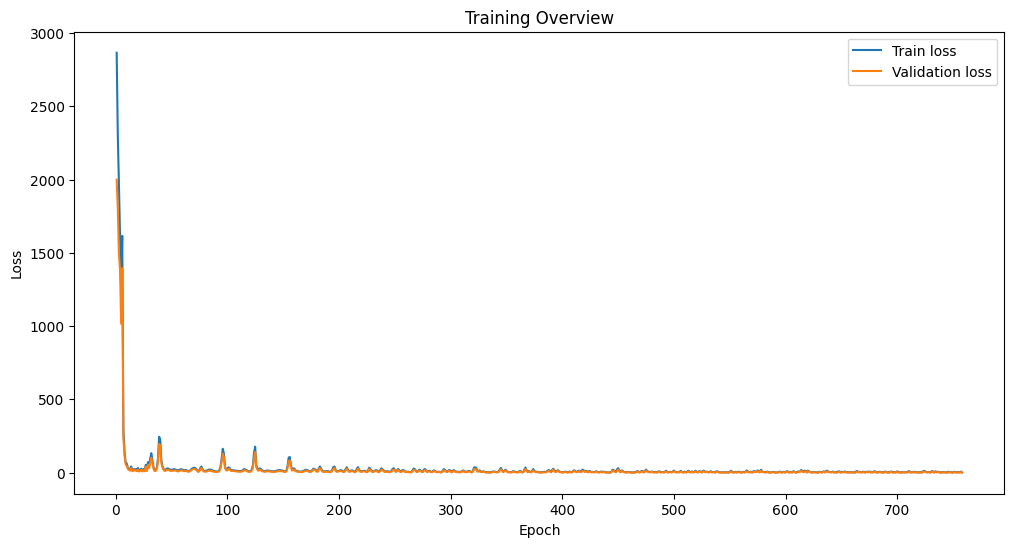

In [40]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(range(1, len(TRLossHist) + 1), TRLossHist, label='Train loss')
ax.plot(range(1, len(VLLossHist) + 1), VLLossHist, label='Validation loss')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Overview')
ax.legend()


# LOSS chart


In [25]:
def scatter(y_true, y_pred):
    f, ax = plt.subplots(1, 1, figsize=(7, 7))
    palette = sns.color_palette()

    min_value = min(np.amin(y_true), np.amin(y_pred))
    max_value = max(np.amax(y_true), np.amax(y_pred))
    y_mid = np.linspace(min_value, max_value)

    ax.plot(y_mid, y_mid, '--', color=palette[1])
    ax.scatter(y_true, y_pred, color=palette[0], alpha=0.5);

    return f, ax

# KPI Computations

ci stanno da fare questi KPI vedi qui:
https://nbviewer.org/github/srom/distributions/blob/2021-01-05/notebook/NN%20parametrization%20of%20distribution.ipynb

In [41]:

"""
TRmse = mean_squared_error(TRresultDf["target"].to_numpy().flatten(),TRresultDf["mean"].to_numpy().flatten())
TRrmse = mean_squared_error(TRresultDf["target"].to_numpy().flatten(),TRresultDf["mean"].to_numpy().flatten(), squared=False)
TRr2 = r2_score(TRresultDf["target"].to_numpy().flatten(),TRresultDf["mean"].to_numpy().flatten())

print(f"Training KPI: TRmse:{TRmse} \n TRrmse:{TRrmse} \n TRr2: {TRr2}")


VLmse = mean_squared_error(VLresultDf["target"].to_numpy().flatten(),VLresultDf["mean"].to_numpy().flatten())
VLrmse = mean_squared_error(VLresultDf["target"].to_numpy().flatten(),VLresultDf["mean"].to_numpy().flatten(), squared=False)
VLr2 = r2_score(VLresultDf["target"].to_numpy().flatten(),VLresultDf["mean"].to_numpy().flatten())

print(f"Validation KPI: VLmse:{VLmse} \n VLrmse:{VLrmse} \n VLr2: {VLr2}")

"""
TSmse = mean_squared_error(TSresultDf["target"].to_numpy().flatten(),TSresultDf["mean"].to_numpy().flatten())
TSrmse = mean_squared_error(TSresultDf["target"].to_numpy().flatten(),TSresultDf["mean"].to_numpy().flatten(), squared=False)
TSr2 = r2_score(TSresultDf["target"].to_numpy().flatten(),TSresultDf["mean"].to_numpy().flatten())

print(f"Test KPI: TSmse:{TSmse} \n TSrmse:{TSrmse} \n TSr2: {TSr2}")



Test KPI: TSmse:0.0005958412030219523 
 TSrmse:0.024409858725972837 
 TSr2: 0.9480902293021019


In [48]:
def plot_results(y_true, y_pred):
    f, ax = plt.subplots(1, 1, figsize=(10, 6))
    palette = sns.color_palette()

    min_value = min(np.amin(y_true), np.amin(y_pred))
    max_value = max(np.amax(y_true), np.amax(y_pred))
    y_mid = np.linspace(min_value, max_value)

    ax.plot(y_mid, y_mid, '--', color=palette[1])
    ax.scatter(y_true, y_pred, color=palette[0], alpha=0.5);

    return f, ax

## Validation scatter

In [46]:

f, ax = plot_results(
    VLresultDf["target"].to_numpy().flatten(),
    VLresultDf["mean"].to_numpy().flatten(),
);

ax.text(225, 95, f'$R^2 = {VLr2:.2f}$')
ax.text(225, 80, f'$RMSE = {VLrmse:.2f}$')

ax.set_xlabel('Actuals');
ax.set_ylabel('Predictions');
ax.set_title('Regression results on validation set');



NameError: name 'VLresultDf' is not defined

## Test scatter

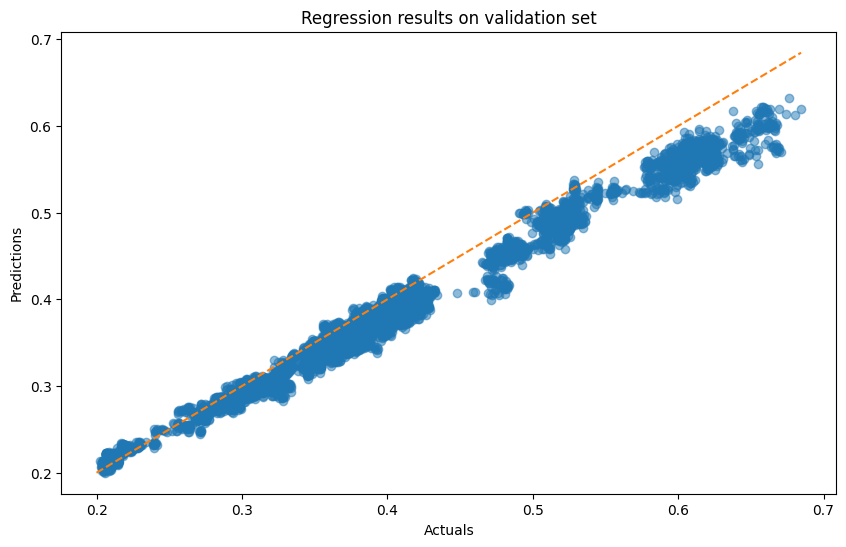

In [58]:


f, ax = plot_results(
    TSresultDf["target"].to_numpy().flatten(),
    TSresultDf["mean"].to_numpy().flatten(),
);



ax.set_xlabel('Actuals');
ax.set_ylabel('Predictions');
ax.set_title('Regression results on validation set');

In [79]:
# model save

model_filename = "/content/drive/MyDrive/Colab Notebooks/NeuroProbabilistico/NeuroProb/NeuroProbPTH/NeuroProbBASE1last.pth"
torch.save(model.state_dict(), model_filename)
print(f'Model saved as {model_filename}')

Model saved as /content/drive/MyDrive/Colab Notebooks/NeuroProbabilistico/NeuroProb/NeuroProbPTH/NeuroProbBASE1last.pth


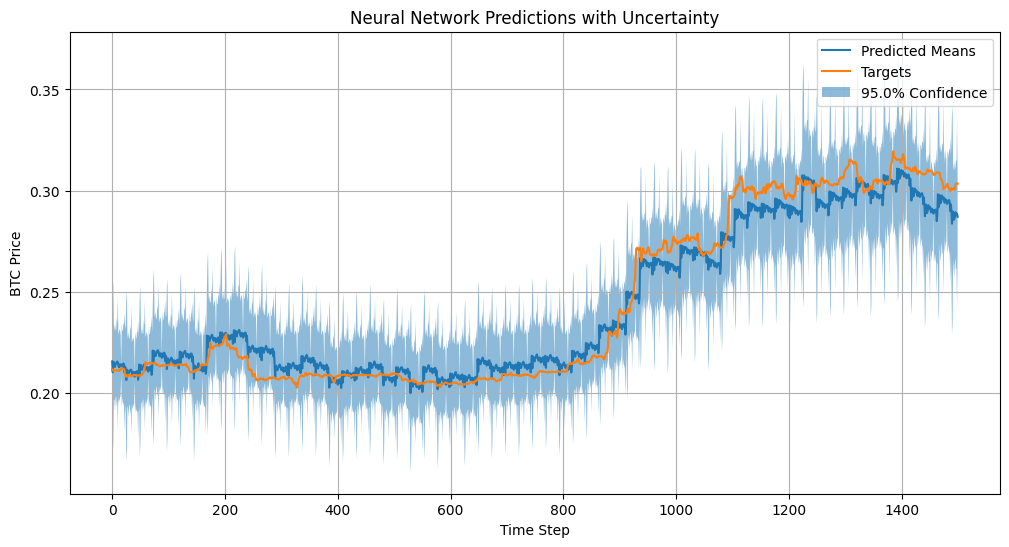

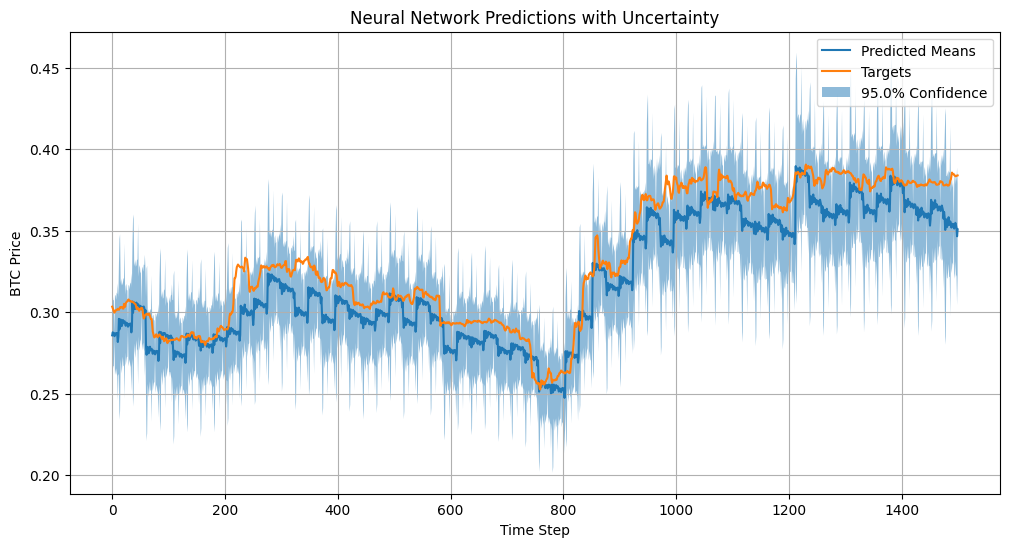

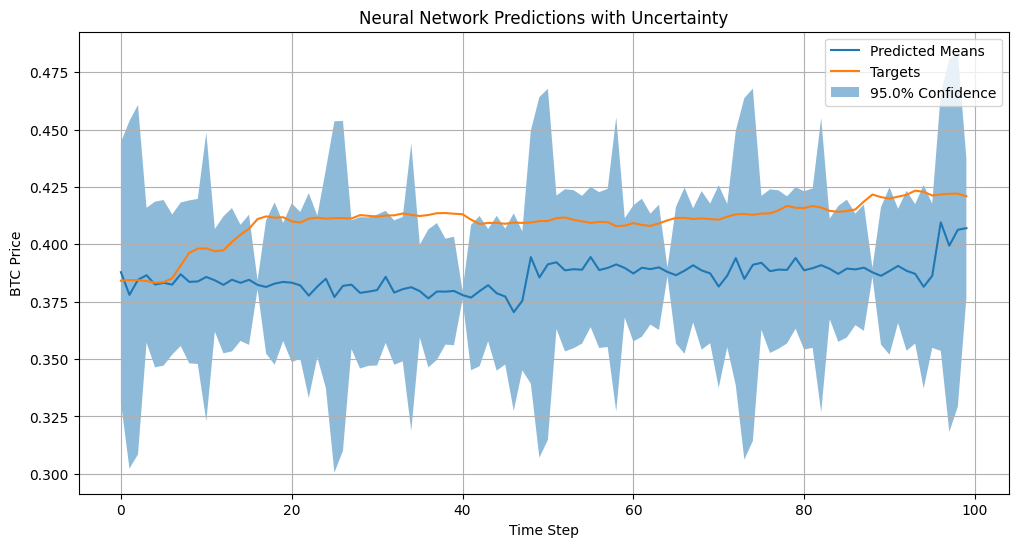

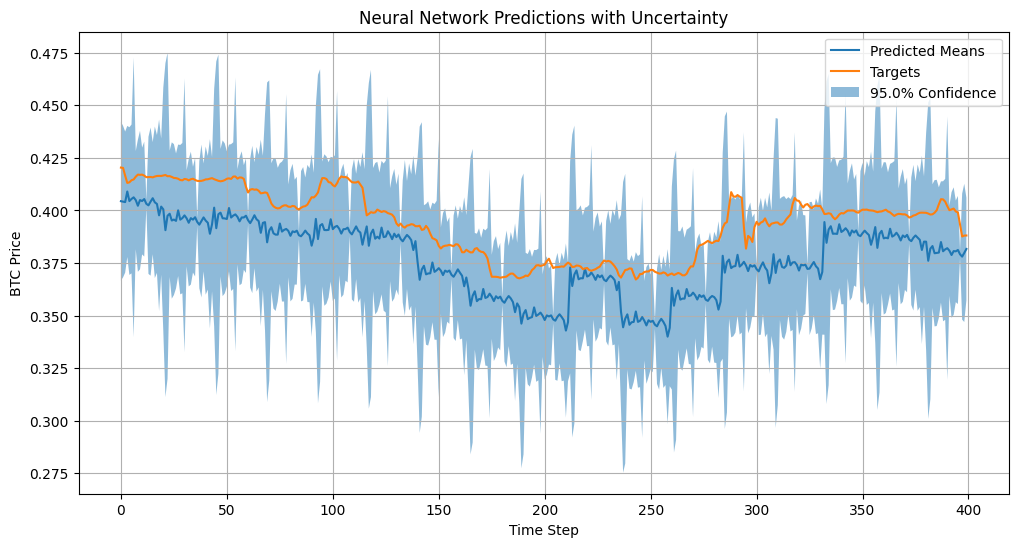

In [81]:
from scipy import stats

def plotPredChart(means,target,confidence_intervals):
  plt.figure(figsize=(12, 6))

# Main prediction line
  plt.plot(means, label='Predicted Means')

# Target values
  plt.plot(target, label='Targets')

# Confidence Intervals
  plt.fill_between(np.arange(len(means)),
                 means - confidence_intervals,
                 means + confidence_intervals,
                 alpha=0.5, label=f'{confidence_level * 100}% Confidence')

# Styling
  plt.xlabel('Time Step')
  plt.ylabel('BTC Price')
  plt.title('Neural Network Predictions with Uncertainty')
  plt.legend()
  plt.grid(True)
  plt.show()


means = TSresultDf["mean"].to_numpy().flatten()
target = TSresultDf["target"].to_numpy().flatten()
confidence_level = 0.95
alpha = 1 - confidence_level
z_critical = np.abs(stats.norm.ppf(alpha / 2))  # Two-tailed critical value

confidence_intervals = z_critical *  TSresultDf["std"].to_numpy().flatten()

plotPredChart(means[:1500],target[:1500],confidence_intervals[:1500])
plotPredChart(means[1500:3000],target[1500:3000],confidence_intervals[1500:3000])
plotPredChart(means[3000:3100],target[3000:3100],confidence_intervals[3000:3100])
plotPredChart(means[3100:3500],target[3100:3500],confidence_intervals[3100:3500])

In [ ]:
class EnhancedCNNLSTMModel(nn.Module):
    def __init__(self, input_size, num_lstm_layers, dropout, sequence_length, nStepsAhead):
        super().__init__()

        self.hybridNetwork = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=sequence_length, kernel_size=3),
            nn.ReLU(),
            nn.LSTM(input_size=sequence_length, hidden_size=64, num_layers=2,
                    dropout=dropout, batch_first=False, bidirectional=True),
            nn.TransformerEncoderLayer(d_model=64, nhead=4) # Example attention layer
        )

        self.endLinearLayer = nn.Linear(128, 2 * nStepsAhead) # Output mean & covariance

    def forward(self, x):
        # ... (rest of the forward pass logic)

        # Output modification for Gaussian distribution
        x = self.endLinearLayer(x)
        means, covariances = x.chunk(2, dim=-1)
        return means, covariances


In [ ]:
class Seq2SeqCNNLSTMModel(nn.Module):
    # ... (Your initialization as before) ...

    def forward(self, x):
        # CNN Layers
        x = x.permute(0, 2, 1)
        x = self.hybridNetwork[0](x)
        x = self.hybridNetwork[1](x)

        # Encoder LSTM
        x, (encoder_hidden, encoder_cell) = self.hybridNetwork[2](x)

        # Decoder (Simplified)
        outputs = []
        decoder_input = x[-1, :, :]  # Start with encoder's last output
        for _ in range(desired_output_length):
            decoder_output, (decoder_hidden, decoder_cell) = self.decoder_lstm(decoder_input, (encoder_hidden, encoder_cell))
            outputs.append(decoder_output)
            decoder_input = decoder_output  # Feedback

        # Process outputs with a final linear layer
        outputs = torch.stack(outputs, dim=1)  # Combine into a sequence
        outputs = self.endLinearLayer(outputs)

        # ... (Distribution generation if needed) ...

        return outputs


In [ ]:
"KATY-AI-CNNLSTM-NEUROPROB"

class CNNLSTMModel(nn.Module):

  def __init__(self, input_size, num_lstm_layers, dropout,
               sequence_length,nStepsAhead):
    super().__init__()
    self.jitter = 1e-6

    # model definition
    self.hybridNetwork = nn.Sequential(
        nn.Conv1d(in_channels=input_size,
                  out_channels=sequence_length,
                  kernel_size=1),
        nn.ReLU(),
        nn.LSTM(input_size=sequence_length,
                hidden_size=sequence_length,
                num_layers=num_lstm_layers,
                dropout=dropout,
                batch_first=False,bidirectional=True),
    )
    self.endLinearLayer = nn.Linear(2 * sequence_length,2 * nStepsAhead)

  def forward(self, x):
    # Apply CNN layers
    x = x.permute(0, 2, 1)
    x = self.hybridNetwork[0](x)  # Conv1d
    x = self.hybridNetwork[1](x)  # ELU activation

    # Permute the dimensions for LSTM
    x = x.permute(2, 0, 1)

    # Apply LSTM layers
    x, (hidden, cell) = self.hybridNetwork[2](x)

    # Only take the output from the last time-step
    x = x[-1, :, :]

    # Apply final linear layer
    x = self.endLinearLayer(x)
    means ,variances = x.chunk(2, dim = -1)
    variances = self.jitter + variances
    variances = torch.clamp(variances, min=1e-3)  # Enforce a minimum positive variance
    distributions = torch.distributions.Normal(means, variances)


    return distributions


In [ ]:
import pandas as pd
mean = []
var = []
a = [[x for x in range(0,24,1)], [x for x in range(24,0,-1)], [x for x in range(0,48,2)], [x for x in range(48,0,-2)],[x for x in range(0,64,4)], [x for x in range(64,0,-4)]]
# a = [[mean1,var1],[mean2,var2]........]

b = a[::2]
c = a[1::2]
df = pd.DataFrame({
    "means" : b,
    "stdv": c,
})
print(b)
print(c)
df.head()

In [ ]:
import pandas as pd

a = [[x for x in range(0,24,1)], [x for x in range(24,0,-1)], [x for x in range(0,48,2)], [x for x in range(48,0,-2)]]

# Initialize lists for separation
mean = []
var = []

# Access and store elements
for inner_list in a:
    mean.append(inner_list[0,:])  # Assuming the first element is the mean
    var.append(inner_list[1,:])  # Assuming the second element is the variance

# Example: Create a DataFrame (optional)
df = pd.DataFrame(list(zip(mean, var)), columns=['mean', 'var'])
print(df)